In [1]:
%matplotlib inline
import pylab as plt
import numpy as np
from AnalyzeCalib import getCM, selCPalgo,cmPredict
from matusplotlib import loadStanFit
NA=np.newaxis

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def compare(dat,excludeNan=True,verbose=False):
    if excludeNan:
        sel=dat[:,:,0].sum(1)>2
        dat=dat[sel,:,:]
    if excludeNan: cn=dat[:,:,0]
    else:cn=1
    A=np.logical_and(np.logical_and(dat[:,:,1]==1,dat[:,:,2]==1),cn==1).sum()
    B=np.logical_and(np.logical_and(dat[:,:,1]==1,dat[:,:,2]==0),cn==1).sum()
    C=np.logical_and(np.logical_and(dat[:,:,1]==0,dat[:,:,2]==1),cn==1).sum()
    D=np.logical_and(np.logical_and(dat[:,:,1]==0,dat[:,:,2]==0),cn==1).sum()
    N=A+B+C+D
    p0=(A+D)/N;pe=(A+B)*(A+C)/N/N+(C+D)*(B+D)/N/N
    kp=(p0-pe)/(1-pe)
    if verbose:
        print(f'\tp0={p0:.3f},kappa={kp:.3f}')
        print('\tsensitivity',A/(A+C),A+C)
        print('\tspecificity',D/(B+D),B+D)
    return kp


def selCPalgoAll(y,c,th,minNrCL,repeat,algo):
    temp=np.zeros(y.shape[:-1])
    for n in range(y.shape[0]):
        for m in range(y.shape[1]):
            P=[5,9][int(m==0 or m==3)]
            res= selCPalgo(y[n,m,:P,:],c[n,m,:P,:],
                threshold=th,minNrCL=minNrCL, repeat=repeat,algo=algo)
            temp[n,m,:P]= np.int32(~np.isnan(res[2][:,0]))
    return temp


In [32]:
tmp

array([[[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 1., 1.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 0., ..., 0., 0., 0.]],

       [[1., 1., 0., ..., 1., 0., 1.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 0., 0., ..., 1., 0., 1.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 1., 1., ..., 1., 1., 1.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[1., 1., 1., ..., 1., 1., 1.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 1., 0., ..., 0., 0., 0.]],

       [[1., 0., 0., ..., 1., 1., 1.],
    

# K015

In [4]:
import ast
MP={5:0,1:1,3:2,9:3,7:4,6:5,4:6,2:7,8:8}
with open('k015/calib.sel','r') as f: dr=ast.literal_eval(f.read())
res=list(dr.values());ids=list(dr.keys())
for h in range(len(ids)):
    ids[h]=np.int32(ids[h].rsplit('_'))
ids=np.array(ids,dtype=np.int32)
D0=np.load('k015/D0.npy')
for n in range(D0.shape[0]):
    sel=np.logical_and(D0[n,0]==ids[:,0],D0[n,1]==ids[:,1]).nonzero()[0]
    assert(len(sel)==1)
    D0[n,-1]= len(res[sel[0]])!=0

D1=np.load('k015/D2.npy')
sel=np.logical_and(~np.any(np.isnan(D1[:,1:-1,1]),1),D0[:,-1]==1)
sel=D0[:,-1]==1
D1=D1[sel,1:-1,1:7]
#D1[:,:,[6,7]]=(D1[:,:,[2,3]]+D1[:,:,[4,5]])/2
#D2=np.load('k015/D2cal.npy')[sel,1:-1,1:9]
#D2[:,:,[6,7]]=(D2[:,:,[2,3]]+D2[:,:,[4,5]])/2
mask=np.ones((D1.shape[0],2,D1.shape[1],5),dtype=np.int32)
D0=D0[sel,:]
for e in range(2):
    mask[:,e,:,0]=1-np.int32(np.isnan(D1[:,:,2+e*2]))
    mask[np.isnan(D1[:,:,2+e*2]).sum(1)>7,e,:,0]=0
    for n in range(D1.shape[0]):
        if np.all(np.isnan(D1[n,:,0])):
            mask[n,e,:,1]=0
            continue
        
        sel=np.logical_and(D0[n,0]==ids[:,0],D0[n,1]==ids[:,1]).nonzero()[0]
        assert(len(sel)==1)
        d=res[sel[0]]
        if len(d)==0: mask[n,e,:,1]=0
        elif len(d)==2:
            for h in d[e]:mask[n,e,MP[h],1]=0
            mask[n,e,np.isnan(D1[n,:,2+e*2]),1]=0
        else:stop
        #if D0[n,0]==67 and D0[n,1]==7:stop

In [34]:
mask.shape

(279, 2, 9, 5)

2.25 0.6711653490950099


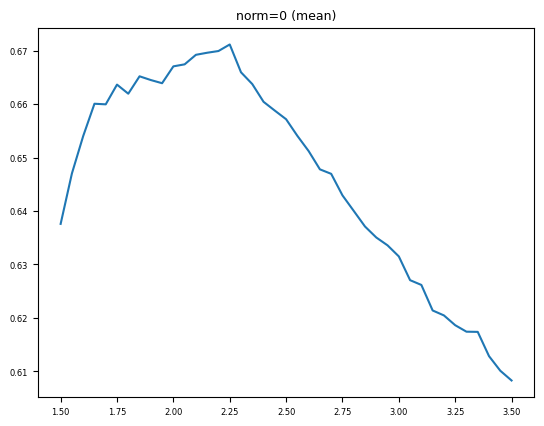

In [5]:
ths=np.linspace(1.5,3.5,41)#th=2.4, norm=0.8
kaps=[]
for t in range(len(ths)): 
    for eye in range(2):
        mask[:,eye,:,2]=np.squeeze(selCPalgoAll(D1[:,NA,:,[2+eye*2,3+eye*2]],D1[:,NA,:,:2],
                                                THACC=ths[t],NORM=0,MINVALIDCL=3))
    shp=list(mask.shape)
    kaps.append(compare(np.reshape(mask,[shp[0]*shp[1]]+shp[2:],order='F')))
plt.plot(ths,kaps)
plt.title('norm=0 (mean)')
th=ths[np.argmax(kaps)]
print(th,np.nanmax(kaps))

In [7]:
for eye in range(2):
    mask[:,eye,:,2]=np.squeeze(selCPalgoAll(D1[:,NA,:,[2+eye*2,3+eye*2]],
        D1[:,NA,:,:2],THACC=ths[t],NORM=0,MINVALIDCL=3))

shp=list(mask.shape)
compare(np.reshape(mask,[shp[0]*shp[1]]+shp[2:],order='F'),verbose=True)
compare(np.reshape(mask,[shp[0]*shp[1]]+shp[2:],order='F'),verbose=True,excludeNan=False)

0.00,0.08
0.01,0.29
0.00,0.21
p0=0.882,kappa=0.608
sensitivity 0.9818660427025446 3419
specificity 0.541 1000
0.04,0.12
0.05,0.32
0.04,0.24
p0=0.896,kappa=0.744
sensitivity 0.9818660427025446 3419
specificity 0.7136618839675608 1603


0.7444951653076327

In [ ]:
eye=0
for n in range(mask.shape[0]):
    plt.figure();
    sel=mask[n,:,eye,1]==mask[n,:,eye,2]
    if np.all(sel):continue
    plt.plot(D1[n,sel,2+2*eye],D1[n,sel,3+2*eye],'.g');
    plt.plot(D1[n,~sel,2+2*eye],D1[n,~sel,3+2*eye],'.r');
    plt.plot(D1[n,:,0],D1[n,:,1],'.y');
    plt.title(n);

[1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 0 1 1]
[143   7]


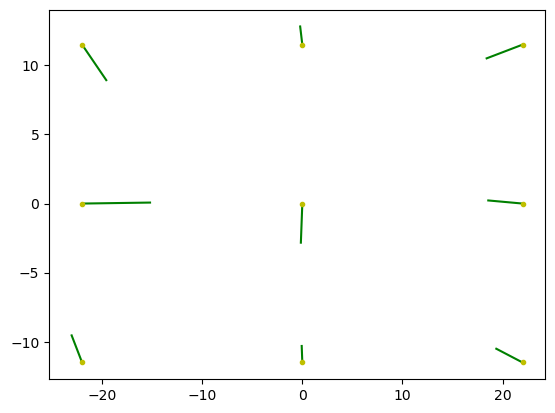

In [9]:
n=245
print(mask[n,:,eye,1])
print(mask[n,:,eye,2])
for k in range(9):
    plt.plot(D1[n,k,[2+2*eye,0]],D1[n,k,[3+2*eye,1]],'-g');
    plt.plot(D1[n,k,0],D1[n,k,1],'.y');
print(D0[n,:2])

In [ ]:
D0=np.load('k015/D0.npy')
D1=np.load('k015/D2.npy')
print(D1.shape)
sel=~np.all(np.isnan(D1[:,1:-1,1]),1)
D0=D0[sel,:]
D1=D1[sel,1:-1,1:7]
print(D1.shape)
#print(mask[n,:,eye,1])
#print(mask[n,:,eye,2])
f=open('k015/am.txt','w')
for n in range(D1.shape[0]):
    for eye in range(2):
        fig,ax=plt.subplots()
        for k in range(9):
            ax.plot(D1[n,k,[2+2*eye,0]],D1[n,k,[3+2*eye,1]],'-g');
        ax.scatter(D1[n,:,0],D1[n,:,1],color='y');
        ttl=f'{D0[n,0]}_{D0[n,1]}_{eye}'
        plt.title(ttl)
        txtout=f'{D0[n,0]},{D0[n,1]},{eye},'
        for k,h in enumerate([5,1,3,9,7,6,4,2,8]):
            if not np.isnan(D1[n,k,2+2*eye]): ax.annotate(f'{h}',(D1[n,k,0],D1[n,k,1]))
            else:txtout+=f'{h},'
        f.write(txtout+'\n')
        #plt.savefig(f'k015/clb/{n*2+eye:03d}.png')
f.close()

# CP selection, K018

In [3]:
from matusplotlib import loadStanFit
w=loadStanFit(f'data/sm2L09ThaccInfdva02211')
y=w['y+']
c=w['c+']
msk=w['mask+']
MAP=[5,1,3,9,7,6,4,2,8]

In [4]:
m=2;n=0
coef,resid,cnew=getCMsingle(y[n,m,:,:],c[n,m,:,:],residVec=True)
resid

array([0.78408499, 0.43718253, 0.66293705, 0.39555013, 0.41398802,
              nan,        nan,        nan,        nan])

In [16]:
cnew

array([[ 12.78765849,  -8.30329926],
       [ -6.61271215,  13.16027383],
       [ 34.95508973,  12.25106153],
       [ 33.39206384, -27.5415143 ],
       [ -6.35488793, -26.98679585],
       [         nan,          nan],
       [         nan,          nan],
       [         nan,          nan],
       [         nan,          nan]])

In [19]:
np.sqrt(np.square(pred-c[n,m,:,:]).sum(1))

array([0.53661331, 0.68830515, 0.59053588, 0.44522932, 1.18640848,
       1.1133288 , 0.32921409, 0.91420083, 0.89807989])

In [4]:
import matplotlib.patches as mpatches
from matplotlib.transforms import Bbox
# generate pictures and coding file for human rater
mask=np.zeros(list(y.shape[:3])+[5])
f=open('clb/out.txt','w')
for n in range(y.shape[0]):
    for m in range(6):
        if msk[n,m]==0: continue
        coef,resid,dis=getCMsingle(y[n,m,:,:],c[n,m,:,:])
        pred=cmPredict(y[n,m,:,:],coef)
        fig,ax=plt.subplots(figsize=[6,6])
        P=[5,9][int(m==0 or m==3)]
        for k in range(P):
            ax.plot([pred[k,0],c[n,m,k,0]],[pred[k,1],c[n,m,k,1]],'-g');
            circ=plt.Circle((c[n,m,k,0],c[n,m,k,1]), .5,ec='k',facecolor='w',alpha=.5)
            ax.add_patch(circ)
        #ax.plot(,'yo',ms=1);
        ttl=f'{n}, {m},   '
        plt.title(ttl)
        for k,h in enumerate(MAP[:P]):
            if not np.isnan(pred[k,0]): 
                mask[n,m,k,0]=1
                ax.annotate(f'{h}',c[n,m,k,:]+1,alpha=.1)
            else:ttl+=f'{h},'
        f.write(ttl+'\n')
        ax.set_aspect(1)
        plt.xlim([-17,17]);plt.ylim([-17,17]);
        ax.set_xticks([]);ax.set_yticks([])
        plt.tight_layout(pad=.1)
        plt.savefig(f'clb/pics/{n*6+m:04d}.png',dpi=400)
        plt.cla()
        plt.close()
        del circ
        
f.close()

In [4]:
c

array([[[[  0.        ,   0.        ],
         [-13.43903524,  13.43903524],
         [ 13.43903524,  13.43903524],
         ...,
         [-13.43903524,   0.        ],
         [  0.        ,  13.43903524],
         [  0.        , -13.43903524]],

        [[  0.        ,   0.        ],
         [-13.43903524,  13.43903524],
         [ 13.43903524,  13.43903524],
         ...,
         [         nan,          nan],
         [         nan,          nan],
         [         nan,          nan]],

        [[  0.        ,   0.        ],
         [-13.43903524,  13.43903524],
         [ 13.43903524,  13.43903524],
         ...,
         [         nan,          nan],
         [         nan,          nan],
         [         nan,          nan]],

        [[  0.        ,   0.        ],
         [-13.43903524,  13.43903524],
         [ 13.43903524,  13.43903524],
         ...,
         [         nan,          nan],
         [  0.        ,  13.43903524],
         [  0.        , -13.43903524]],



In [6]:
#read rater's file
MAP=[5,1,3,9,7,6,4,2,8]
with open('clb/ms.txt','r') as f: lns=f.readlines()
mask[:,:,:,1]=0
for ln in lns:
    ln=ln.replace(' ','')
    tmp=ln.rstrip('\n').rsplit(',')
    if tmp[-1]=='':tmp.pop()
    vs=list(map(int,tmp))
    P=[5,9][int(vs[1]==0 or vs[1]==3)]
    mask[vs[0],vs[1],:P,1]=1
    for v in vs[2:]:
        mask[vs[0],vs[1],MAP.index(v),1]=0

1.75 0.679267129607234


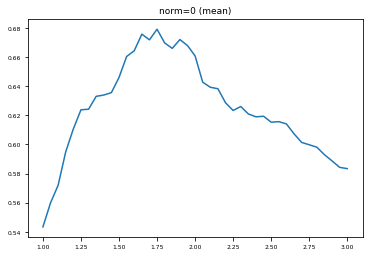

In [9]:
ths=np.linspace(1,3,41)#th=2.4, norm=0.8
kaps=[]
for t in range(len(ths)): 
    mask[:,:,:,2]=selCPalgoAll(y,c,THACC=ths[t],NORM=0,MINVALIDCL=3)
    shp=list(mask.shape)
    kaps.append(compare(np.reshape(mask,[shp[0]*shp[1]]+shp[2:],order='F')))
plt.plot(ths,kaps)
plt.title('norm=0 (mean)')
th=ths[np.argmax(kaps)]
print(th,np.max(kaps))

In [15]:
mask[:,:,:,2]=selCPalgoAll(y,c,THACC=th,NORM=0,MINVALIDCL=3)
shp=list(mask.shape)
compare(np.reshape(mask[:,:,:,[0,1,2]],[shp[0]*shp[1]]+[shp[2],3],order='F'),verbose=True);
#compare(np.reshape(mask,[shp[0]*shp[1]]+shp[2:],order='F'),verbose=True,excludeNan=False)

0.00,0.37
0.06,0.44
0.06,0.44
p0=0.941,kappa=0.679
sensitivity 0.9728322390762961 4417
specificity 0.6772983114446529 533


# rater 1 vs stan model

In [13]:
xo=np.median(w['onTargetGen'],0).flatten()
#x=np.log(x/(1-x))
yo=mask[:,:,:,1].flatten()
np.logical_and(xo>.1,xo<.9).mean()

0.0150519978106185

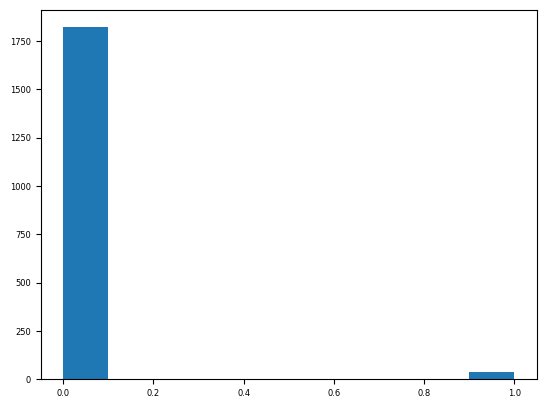

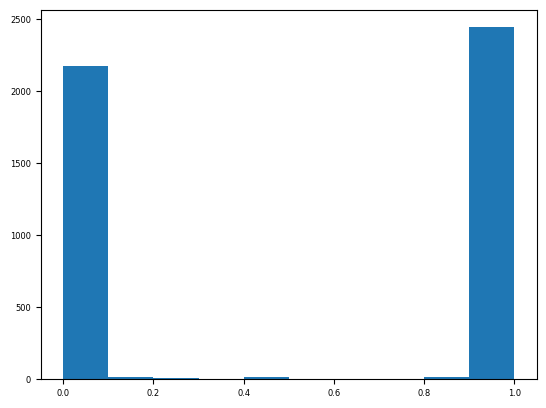

In [47]:
plt.hist(xo[yo==0]);
plt.figure()
plt.hist(xo[yo==1]);

In [22]:
mask[:,:,:,3]=np.int32(np.median(w['onTargetGen'],0)>.5)
dat=np.reshape(mask[:,:,:,[0,1,3]],[shp[0]*shp[1]]+[shp[2],3],order='F')
compare(dat,verbose=True)
#compare(dat,verbose=True,excludeNan=False);

0.00,0.37
0.06,0.44
0.01,0.42
p0=0.914,kappa=0.468
sensitivity 0.9735114330993887 4417
specificity 0.4202626641651032 533


0.4678754434371305

In [49]:
for k in range(3,10):
    sel=dat[:,:,0].sum(1)==k
    compare(dat[sel,:,:],verbose=True)

0.00,0.67
0.60,0.87
0.01,0.70
p0=0.499,kappa=0.133
sensitivity 0.9947916666666666 192
specificity 0.1649122807017544 285
0.00,0.56
0.55,0.82
0.00,0.60
p0=0.497,kappa=0.124
sensitivity 0.9959183673469387 245
specificity 0.15211267605633802 355
0.00,0.44
0.47,0.72
0.00,0.48
p0=0.555,kappa=0.112
sensitivity 0.9906396255850234 641
specificity 0.12111801242236025 644
0.00,0.33
0.61,0.75
0.00,0.41
p0=0.452,kappa=0.087
sensitivity 0.9516129032258065 62
specificity 0.16037735849056603 106
0.00,0.22
0.59,0.71
0.00,0.33
p0=0.512,kappa=0.171
sensitivity 0.9907407407407407 108
specificity 0.22346368715083798 179
0.00,0.11
0.52,0.59
0.00,0.22
p0=0.558,kappa=0.168
sensitivity 0.9783549783549783 231
specificity 0.20146520146520147 273
0.00,0.00
0.45,0.46
0.00,0.08
p0=0.606,kappa=0.156
sensitivity 0.9863481228668942 879
specificity 0.16 750


# CPselAlgo vs stan model

In [18]:
masktmp=np.copy(mask[:,:,:,[0,3,2]])
masktmp[:,:,:,2]=selCPalgoAll(y,c,THACC=1.75,NORM=0,MINVALIDCL=3)
shp=list(masktmp.shape)
compare(np.reshape(masktmp,[shp[0]*shp[1]]+shp[2:],order='F'),verbose=True)

0.00,0.37
0.07,0.43
0.06,0.44
p0=0.940,kappa=0.644
sensitivity 0.962322695035461 4512
specificity 0.7100456621004566 438


0.6438326096847291

1.7000000000000002 0.6411689398788715


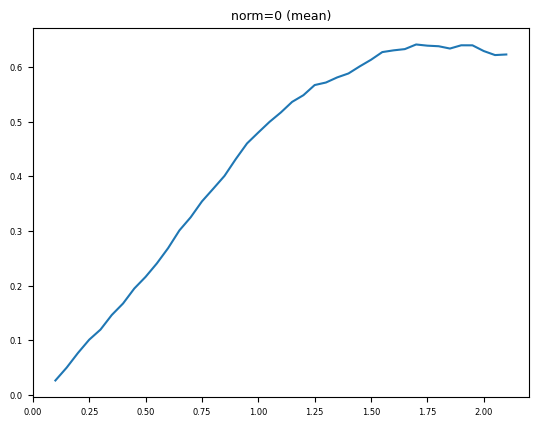

In [17]:
ths=np.linspace(.1,2.1,41)#th=2.4, norm=0.8
kaps=[]
for t in range(len(ths)): 
    masktmp[:,:,:,2]=selCPalgoAll(y,c,THACC=ths[t],NORM=0,MINVALIDCL=3)
    shp=list(masktmp.shape)
    kaps.append(compare(np.reshape(masktmp,[shp[0]*shp[1]]+shp[2:],order='F')))
plt.plot(ths,kaps)
plt.title('norm=0 (mean)')
th=ths[np.argmax(kaps)]
print(th,np.max(kaps))

In [18]:
masktmp[:,:,:,2]=selCPalgoAll(y,c,THACC=th,NORM=0,MINVALIDCL=3)
shp=list(masktmp.shape)
compare(np.reshape(masktmp,[shp[0]*shp[1]]+shp[2:],order='F'),verbose=True)

0.00,0.37
0.08,0.44
0.06,0.44
p0=0.936,kappa=0.641
sensitivity 0.9630376344086021 4464
specificity 0.6851851851851852 486


0.6411689398788715

# Tuning

In [3]:

w=loadStanFit(f'data/sm2L09ThaccInfdva02211')
y=w['y+']
c=w['c+']
msk=w['mask+']
MAP=[5,1,3,9,7,6,4,2,8]
VALID,RATER1,RATER2,ALGO,ALGOT,TRUTH=range(6)
# get data about invalid measurements
mask=np.zeros(list(y.shape[:3])+[TRUTH+1])
for n in range(y.shape[0]):
    for m in range(6):
        if msk[n,m]==0: continue
        P=[5,9][int(m==0 or m==3)]
        for k,h in enumerate(MAP[:P]):
            if not np.isnan(y[n,m,k,0]): mask[n,m,k,VALID]=1
#read rater's file
def readRater(fn):
    with open(f'clb/{fn}.txt','r') as f: lns=f.readlines()
    out=np.zeros(mask.shape[:3])
    for ln in lns:
        ln=ln.replace(' ','')
        tmp=ln.rstrip('\n').rsplit(',')
        if tmp[-1]=='':tmp.pop()
        #print(tmp)
        vs=list(map(int,tmp))
        P=[5,9][int(vs[1]==0 or vs[1]==3)]
        out[vs[0],vs[1],:P]=1
        for v in vs[2:]:
            out[vs[0],vs[1],MAP.index(v)]=0
    for n in range(out.shape[0]):
        for m in range(out.shape[1]):
            if out[n,m,:].sum()<3: out[n,m,:]=0
    return out
mask[:,:,:,RATER1]=readRater('ms')
mask[:,:,:,RATER2]=readRater('ms2')
mask[:,:,:,TRUTH]=np.int32(np.median(w['onTargetGen'],0)>.5)

In [4]:
mask[:,:,:,ALGO]=selCPalgoAll(y,c,th=2,minNrCL=3,repeat='trial',algo='local')
mask[:,:,:,ALGOT]=selCPalgoAll(y,c,th=2,minNrCL=3,repeat='trial',algo='avg')
nm=['valid','rater','rater2','algo','algoT','truth']
for k in range(len(nm)):
    sel=mask[:,:,:,k].sum(2)==0
    print(f'{nm[k]}: {sel.mean():.2f},{1-mask[:,:,:,k].mean():.2f}')
shp=list(mask.shape)
dat=np.reshape(mask,[shp[0]*shp[1]]+shp[2:],order='F')

print('algo vs rater')
compare(dat[:,:,[VALID,ALGOT,RATER2]],verbose=True); 
print('rater vs truth')
compare(dat[:,:,[VALID,RATER2,TRUTH]],verbose=True); 
print('algo vs truth')
compare(dat[:,:,[VALID,ALGOT,TRUTH]],verbose=True); 
if False:
    print('\n\n')
    print('algoT vs rater')
    compare(dat[:,:,[VALID,ALGOT,RATER1]],verbose=True); 
    print('algoT vs truth')
    compare(dat[:,:,[VALID,ALGOT,TRUTH]],verbose=True); 

valid: 0.16,0.53
rater: 0.32,0.60
rater2: 0.37,0.62
algo: 0.43,0.66
algoT: 0.28,0.55
truth: 0.19,0.56
algo vs rater
	p0=0.844,kappa=0.000
	sensitivity 1.0 4180
	specificity 0.0 770
rater vs truth
	p0=0.878,kappa=0.398
	sensitivity 0.8878281622911695 4609
	specificity 0.7419354838709677 341
algo vs truth
	p0=0.931,kappa=0.000
	sensitivity 1.0 4609
	specificity 0.0 341


In [14]:
ths=np.linspace(0.5,5.5,51)#th=2.4, norm=0.8
nrms=[0]#[0,.5,1,2,4,8,16,32]
als=['avg','local','iter']
mncs=[3,4,-1,0]
kaps=np.zeros((len(als),len(mncs),ths.size,2))
for a in range(len(als)):
    for b in range(len(mncs)):
        print(b)
        for t in range(len(ths)): 
            mask[:,:,:,ALGOT]=selCPalgoAll(y,c,th=ths[t],
                minNrCL=mncs[b],repeat=None,algo=als[a])
            shp=list(mask.shape)
            dat=np.reshape(mask,[shp[0]*shp[1]]+shp[2:],order='F')
            kaps[a,b,t,0]=compare(dat[:,:,[VALID,ALGOT,RATER2]])
            kaps[a,b,t,1]=compare(dat[:,:,[VALID,ALGOT,TRUTH]])

0
1
2
3
0
1
2
3
0
1
2
3


avg 3 3.5, 0.342
avg 4 3.5, 0.247
avg -1 3.5, 0.174
avg 0 2.1, 0.096
local 3 5.0, 0.440
local 4 3.6, 0.299
local -1 4.6, 0.182
local 0 4.1, 0.096
iter 3 2.6, 0.589
iter 4 1.8, 0.348
iter -1 2.7, 0.191
iter 0 2.1, 0.096


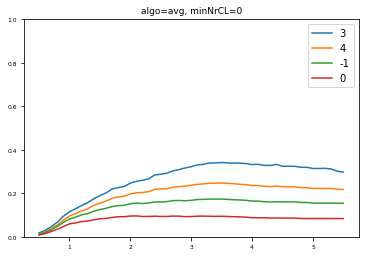

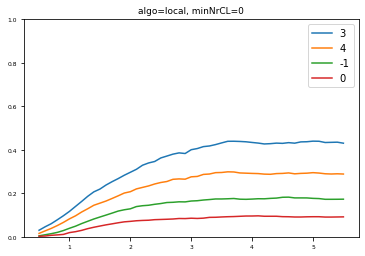

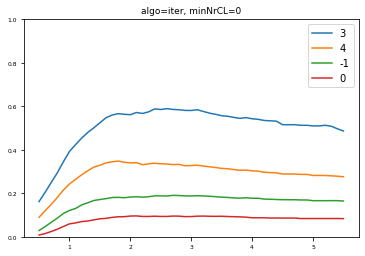

In [17]:
for a in range(len(als)):
    plt.figure()
    for b in range(len(mncs)):
        #plt.plot(ths,kaps[:,k,0])
        plt.plot(ths,kaps[a,b,:,1])
        plt.title(f'algo={als[a]}, minNrCL={mncs[b]}')
        plt.ylim([0,1])
        th=ths[np.argmax(kaps[a,b,:,1])]
        #plt.plot([ths[0],ths[-1]],[.398,.398])
        print(f'{als[a]} {mncs[b]} {th:.1f}, {np.max(kaps[a,b,:,1]):.3f}')
    plt.legend(mncs) 

0 5.0 0.43986953339749124


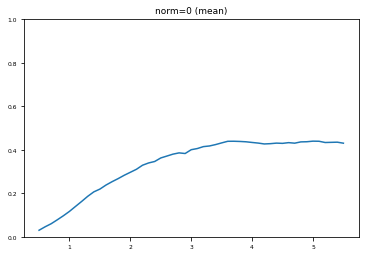

In [16]:
for k in range(len(nrms)):
    plt.figure()
    #plt.plot(ths,kaps[:,k,0])
    plt.plot(ths,kaps[:,k,1])
    plt.title(f'norm={nrms[k]} (mean)')
    plt.ylim([0,1])
    th=ths[np.argmax(kaps[:,k,1])]
    #plt.plot([ths[0],ths[-1]],[.398,.398])
    print(nrms[k],th,np.max(kaps[:,k,1]))

0 3.5 0.34168898699791134


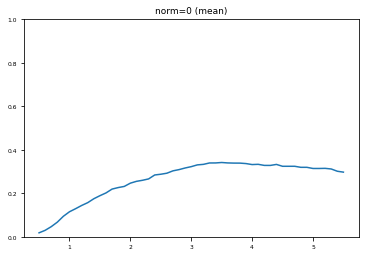

In [18]:
for k in range(len(nrms)):
    plt.figure()
    #plt.plot(ths,kaps[:,k,0])
    plt.plot(ths,kaps[:,k,1])
    plt.title(f'norm={nrms[k]} (mean)')
    plt.ylim([0,1])
    th=ths[np.argmax(kaps[:,k,1])]
    #plt.plot([ths[0],ths[-1]],[.398,.398])
    print(nrms[k],th,np.max(kaps[:,k,1]))

0 3.5 0.24740006189087033


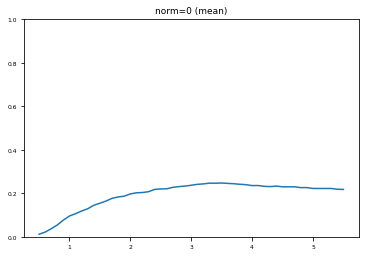

In [20]:
for k in range(len(nrms)):
    plt.figure()
    #plt.plot(ths,kaps[:,k,0])
    plt.plot(ths,kaps[:,k,1])
    plt.title(f'norm={nrms[k]} (mean)')
    plt.ylim([0,1])
    th=ths[np.argmax(kaps[:,k,1])]
    #plt.plot([ths[0],ths[-1]],[.398,.398])
    print(nrms[k],th,np.max(kaps[:,k,1]))